In [25]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

# Regression Analysis: Seasonal Effects with Sklearn Linear Regression
In this notebook, you will build a SKLearn linear regression model to predict Yen futures ("settle") returns with *lagged* Yen futures returns. 

In [26]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
yen_futures = pd.read_csv(
    Path("yen.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2.0,1.0
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0


In [27]:
# Trim the dataset to begin on January 1st, 1990
yen_futures = yen_futures.loc["1990-01-01":, :]
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,NaN,6847.0,48336.0,51473.0
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206.0,53860.0
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649.0,55699.0
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944.0,53111.0
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763.0,52072.0


# Data Preparation

### Returns

In [28]:
# Create a series using "Settle" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns = yen_futures.Settle.pct_change() * 100
yen_futures['Return'] = returns.copy()
# Drop NaN values
yen_futures = yen_futures.dropna()
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest,Return
Date,,,,,,,,,
2014-02-18,9831.0,9865.0,9734.0,9775.0,42.0,9775.0,203495.0,196924.0,-0.427829
2014-02-19,9768.0,9825.0,9760.0,9773.0,2.0,9773.0,129508.0,197197.0,-0.020460
2014-02-20,9774.0,9837.0,9765.0,9775.0,2.0,9775.0,160202.0,198280.0,0.020465
2014-02-21,9772.0,9776.0,9725.0,9758.0,20.0,9755.0,103091.0,202990.0,-0.204604
2014-02-24,9752.0,9789.0,9740.0,9757.0,2.0,9757.0,90654.0,203114.0,0.020502


### Lagged Returns 

In [29]:
# Create a lagged return using the shift function
yen_futures['Lagged_Return'] = returns.shift()
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest,Return,Lagged_Return
Date,,,,,,,,,,
2014-02-18,9831.0,9865.0,9734.0,9775.0,42.0,9775.0,203495.0,196924.0,-0.427829,0.409123
2014-02-19,9768.0,9825.0,9760.0,9773.0,2.0,9773.0,129508.0,197197.0,-0.020460,-0.427829
2014-02-20,9774.0,9837.0,9765.0,9775.0,2.0,9775.0,160202.0,198280.0,0.020465,-0.020460
2014-02-21,9772.0,9776.0,9725.0,9758.0,20.0,9755.0,103091.0,202990.0,-0.204604,0.020465
2014-02-24,9752.0,9789.0,9740.0,9757.0,2.0,9757.0,90654.0,203114.0,0.020502,-0.204604


### Train Test Split

In [30]:
# Create a train/test split for the data using 2018-2019 for testing and the rest for training
train = yen_futures[:'2020']
test = yen_futures['2018':'2019']

In [31]:
# Create four dataframes:
# X_train (training set using just the independent variables), X_test (test set of of just the independent variables)
X_train = train["Lagged_Return"].to_frame()
X_test = test["Lagged_Return"].to_frame()
# Y_train (training set using just the "y" variable, i.e., "Futures Return"), Y_test (test set of just the "y" variable):
Y_train = train["Return"]
Y_test = test["Return"]

In [32]:
X_train
X_test
Y_train
Y_test

Date
2018-01-02    0.297285
2018-01-03   -0.240479
2018-01-04   -0.213028
2018-01-05   -0.353933
2018-01-08    0.062017
                ...   
2019-10-09   -0.410601
2019-10-10   -0.369458
2019-10-11   -0.564304
2019-10-14    0.151335
2019-10-15   -0.469509
Name: Return, Length: 448, dtype: float64

# Linear Regression Model

In [41]:
# Create a Linear Regression model and fit it to the training data
from sklearn.linear_model import LinearRegression
X = yen_futures['Settle'].to_frame()
y = yen_futures['Settle'].copy()
model = LinearRegression()
model.fit(X, y)

# Fit a SKLearn linear regression using just the training set (X_train, Y_train):
model.fit(X_train, Y_train)

LinearRegression()

# Make predictions using the Testing Data

Note: We want to evaluate the model using data that it has never seen before, in this case: X_test.

In [42]:
# Make a prediction of "y" values using just the test dataset
predictions = model.predict(X_test)

In [51]:
# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
Results = y_test.to_frame()
Results["Predicted Return"] = predictions
Results.head(2)

,Return,Predicted Return
Date,,
2018-01-02,0.297285,-0.006316
2018-01-03,-0.240479,-0.007396


array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
      dtype=object)

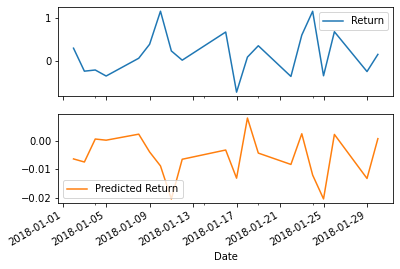

In [44]:
# Plot the first 20 predictions vs the true values
Results[:20].plot(subplots=True)

# Out-of-Sample Performance

Evaluate the model using "out-of-sample" data (X_test and y_test)

In [55]:
from sklearn.metrics import mean_squared_error
# Calculate the mean_squared_error (MSE) on actual versus predicted test "y" 
mse = mean_squared_error(
    Results["Return"],
    Results["Predicted Return"]
)
mse

0.17231639175493815

In [56]:
# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
rmse = np.sqrt(mse)
print(f"Out-of-Sample Root Mean Squared Error (RMSE): {rmse}")

Out-of-Sample Root Mean Squared Error (RMSE): 0.4151100959443629


# In-Sample Performance

Evaluate the model using in-sample data (X_train and y_train)

In [53]:
# Construct a dataframe using just the "y" training data:
in_sample_results = Y_train.to_frame()

# Add a column of "in-sample" predictions to that dataframe:  
in_sample_results["In-sample Predictions"] = model.predict(X_train)

# Calculate in-sample mean_squared_error (for comparison to out-of-sample)
in_sample_mse = mean_squared_error(
    in_sample_results["Return"],
    in_sample_results["In-sample Predictions"]
)
in_sample_mse

0.29751346770480247

In [54]:
# Calculate in-sample root mean_squared_error (for comparison to out-of-sample)
in_sample_rmse = np.sqrt(in_sample_mse)
print(f"In-sample Root Mean Squared Error (RMSE): {in_sample_rmse}")

In-sample Root Mean Squared Error (RMSE): 0.5454479514168171


# Conclusions

YOUR CONCLUSIONS HERE!

According to 2018-2019 test model, a negative trend is expected in the predicted return. As a basic rule of thumb RMSE values between .2 and .5 is relatively accurate. The out of sample roots mean squared error has a accuracy score of .415 suggests that the out of sample data is reliable however the in sample RMSE just falls beyond .5 RMSE. The mean sample error in the out of sample data is 0.172 which is relatively low. Since the MSE is low in the out of sample, the predicted model can be relied on which we see is in the negative. Based on the negative trend graph I have no reason to invest in yen.